# Open Street Map (OSM)

* Community driven
* Anyone can edit / contribute
* Has a great API (which this demo will not take advantage of)
* 

In [8]:
!sudo pip install pyshp


Cleaning up...
Cleaning up...
Cleaning up...


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import osmapi
import pandas as pd
import numpy as np
import shapefile #pyshp
import shapely
import pickle
import geopy
from geopy.distance import vincenty
import networkx as nx
import sys
from lxml import etree
from collections import defaultdict
from io import StringIO, BytesIO

# Raw data from OSM

If you are participating in the workshop, this link will be active:

[https://s3-us-west-1.amazonaws.com/dsworkshop/sm_map.xml](https://s3-us-west-1.amazonaws.com/dsworkshop/sm_map.xml)

Afterwards, I will delete this, and you will need to visit:

[https://www.openstreetmap.org/#map=10/33.9838/-118.2184](https://www.openstreetmap.org/#map=10/33.9838/-118.2184)

In [2]:
rtree = etree.parse("sm_map.xml")

In [14]:
!head -25 sm_map.xml

<?xml version="1.0" encoding="UTF-8"?>
<osm version="0.6" generator="Overpass API">
<note>The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.</note>
<meta osm_base="2015-05-10T17:45:02Z"/>

  <bounds minlat="33.9263" minlon="-118.499" maxlat="34.1053" maxlon="-118.164"/>

  <node id="653656" lat="33.9598406" lon="-118.3770539" version="10" timestamp="2012-08-05T21:43:42Z" changeset="12626769" uid="104962" user="techlady"/>
  <node id="653661" lat="33.9615983" lon="-118.3690656" version="5" timestamp="2012-04-15T01:08:27Z" changeset="11304856" uid="28775" user="StellanL"/>
  <node id="653666" lat="33.9608531" lon="-118.3689360" version="5" timestamp="2012-04-15T01:08:27Z" changeset="11304856" uid="28775" user="StellanL"/>
  <node id="653678" lat="33.9807115" lon="-118.3934249" version="5" timestamp="2010-02-03T21:20:31Z" changeset="3786390" uid="72235" user="Basstoelpel"/>
  <node id="653681" lat="33.9896085" lon="-118.4004080" versio

In [7]:
# WHAT KIND OF ELEMENTS DO WE HAVE?

dir(rtree)

['__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_setroot',
 'docinfo',
 'find',
 'findall',
 'findtext',
 'getelementpath',
 'getiterator',
 'getpath',
 'getroot',
 'iter',
 'iterfind',
 'parse',
 'parser',
 'relaxng',
 'write',
 'write_c14n',
 'xinclude',
 'xmlschema',
 'xpath',
 'xslt']

In [8]:
# WHAT IS IN THE ROOT?

r = rtree.getroot()
dir(r)

['__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__getitem__',
 '__hash__',
 '__init__',
 '__iter__',
 '__len__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_init',
 'addnext',
 'addprevious',
 'append',
 'attrib',
 'base',
 'clear',
 'extend',
 'find',
 'findall',
 'findtext',
 'get',
 'getchildren',
 'getiterator',
 'getnext',
 'getparent',
 'getprevious',
 'getroottree',
 'index',
 'insert',
 'items',
 'iter',
 'iterancestors',
 'iterchildren',
 'iterdescendants',
 'iterfind',
 'itersiblings',
 'itertext',
 'keys',
 'makeelement',
 'nsmap',
 'prefix',
 'remove',
 'replace',
 'set',
 'sourceline',
 'tag',
 'tail',
 'text',
 'values',
 'xpath']

In [3]:
node_counts = defaultdict(int)

children = r.getchildren()
for child in children:
    node_counts[child.tag] += 1

print(node_counts)

defaultdict(<type 'int'>, {'node': 300171, 'remark': 1, 'bounds': 1, 'note': 1, 'meta': 1, 'relation': 566, 'way': 44306})


In [10]:
def rec_print(elem, level=0):
    for i in range(level):
        sys.stdout.write('\t')
    sys.stdout.write(elem.tag)
    if elem.text is not None:
        sys.stdout.write(elem.text)
    ecount = 0
    for k in range(len(elem.keys())):
        key = elem.keys()[k]
        val = elem.values()[k]
        if ecount > 0:
            sys.stdout.write(';')
        sys.stdout.write(' ' + key + '=' + val)
        ecount += 1
    print ''
    for child in elem.getchildren():
        rec_print(child, level+1)

In [16]:
! grep -A 7 '10565341' sm_map.xml

  <node id="10565341" lat="34.0234837" lon="-118.1727565" version="13" timestamp="2012-09-25T16:19:20Z" changeset="13248929" uid="207745" user="NE2">
    <tag k="exit_to" v="Whittier Blvd / Olympic Blvd"/>
    <tag k="highway" v="motorway_junction"/>
    <tag k="is_in:state_code" v="CA"/>
    <tag k="ref" v="19"/>
    <tag k="source" v="usgs_imagery;survey;image;CDOT"/>
    <tag k="source_ref" v="AM909_DSCV1401"/>
  </node>
--
    <nd ref="10565341"/>
    <nd ref="658940249"/>
    <nd ref="29414044"/>
    <nd ref="658940248"/>
    <nd ref="10565342"/>
    <nd ref="19344946"/>
    <tag k="hgv" v="designated"/>
    <tag k="hgv:national_network" v="yes"/>
--
    <nd ref="10565341"/>
    <nd ref="74376899"/>
    <nd ref="74376902"/>
    <tag k="highway" v="motorway_link"/>
    <tag k="oneway" v="yes"/>
    <tag k="source" v="usgs_imagery;survey;image;CDOT"/>
    <tag k="source_ref" v="AM909_DSCV1401"/>
  </way>


## OSM Nodes
* Vertex
* Point with metadata

## OSM Ways
* Collection of Nodes
* Additional metadata
* Linear features
* Area boundaries

## OSM Relation
* Describe relationships and groups
* For example, bike route on multiple roads
* For example, turning restrictions

## Tags
* Key Value pairs of extra data

In [4]:
tags = {}
interesting = ['node', 'relation', 'way']
for interest in interesting:
    tags[interest] = defaultdict(int)

for child in children:
    tag = child.tag
    if tag == 'node' or tag == 'relation' or tag == 'way':
        tag_counts = tags[tag]
        gchildren = child.getchildren()
        for gchild in gchildren:
            key = gchild.get('k')
            tag_counts[key] += 1

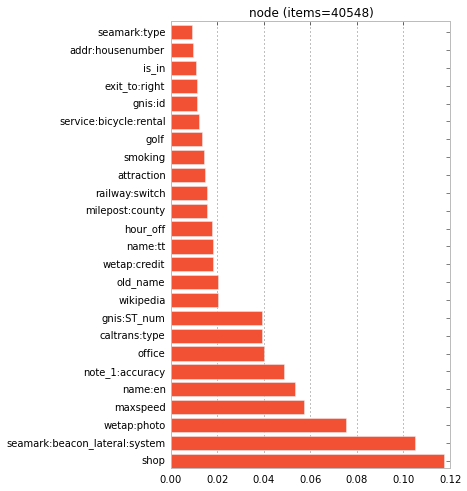

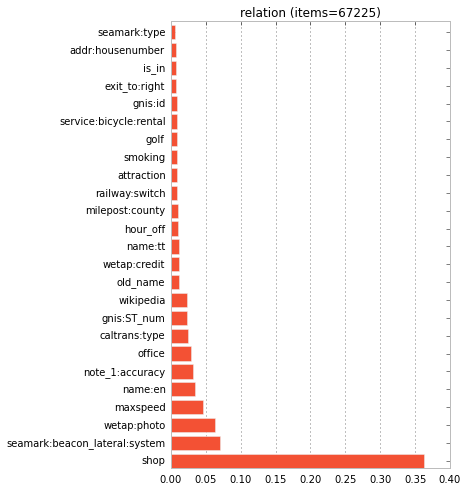

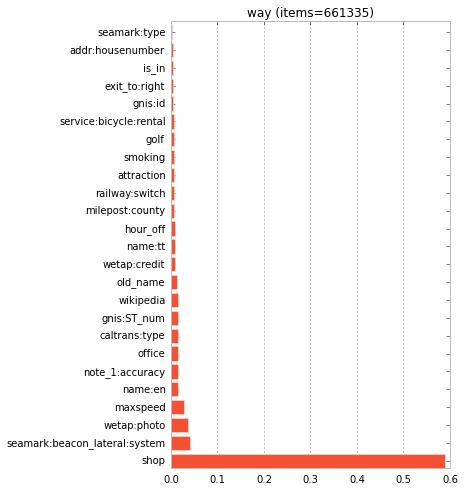

In [5]:
keys = []
counts = []
for tc in tags.keys():
    tag_counts = tags[tc]
    for tag in tag_counts.keys():
        keys.append(tag)
        counts.append(tag_counts[tag])
    df = pd.DataFrame({'key': keys, 'count': counts})
    df.sort('count', ascending=0, inplace=True)
    n = 25
    x = np.arange(n)
    s = df['count'].sum()
    plt.figure(figsize=(5,8))
    plt.barh(x, df['count'][0:n]/s)
    plt.yticks(x+0.4, df['key'])
    plt.gca().yaxis.grid(False)
    plt.title(tc + ' (items=' + str(s) + ')')
    plt.show()

In [17]:
!cat sm_map.xml | grep -i "Ralphs\|Ralph's"

    <tag k="name" v="Ralphs"/>
    <tag k="name" v="Ralphs"/>
    <tag k="name" v="Ralph's"/>
    <tag k="name" v="Ralphs"/>
    <tag k="name" v="Ralph's"/>
    <tag k="name" v="Ralphs"/>
    <tag k="name" v="Ralphs"/>
    <tag k="name" v="Ralphs"/>
    <tag k="name" v="Ralph's"/>
    <tag k="name" v="Ralphs"/>
    <tag k="store_name" v="Ralphs Cloverfield"/>
    <tag k="name" v="Ralphs"/>
    <tag k="name" v="Ralphs"/>
    <tag k="old_name" v="Ralphs Grocery Store"/>
    <tag k="wikipedia" v="en:Ralphs Grocery Store (Los Angeles, California)"/>
    <tag k="name" v="Ralphs"/>
    <tag k="website" v="https://www.ralphs.com/storeHours?store=70300277"/>
    <tag k="name" v="Ralphs"/>
    <tag k="website" v="https://www.ralphs.com/storeHours?store=70300185"/>
    <tag k="name" v="Ralphs"/>
    <tag k="website" v="https://www.ralphs.com/storeHours?store=70300044"/>
    <tag k="name" v="Ralphs"/>


In [15]:
# EXTRACT ROADS

roads = {}
values = defaultdict(int)
children = r.getchildren()
for child in children:
    tag = child.tag
    if tag == 'way':
        gchildren = child.getchildren()
        for gchild in gchildren:
            k = gchild.get('k')
            if k=='highway':
                i = child.keys().index('id')
                road_id = child.values()[i]
                v = gchild.get('v')
                if v=='primary' or v=='secondary' or v=='tertiary' or v=='residential':
                    roads[road_id] = child
                values[v] += 1

In [16]:
# EASY LOOK UP FOR NODES

nodes = {}
children = r.getchildren()
for child in children:
    tag = child.tag
    if tag == 'node':
        ref = child.values()[child.keys().index('id')]
        lat = float(child.values()[child.keys().index('lat')])
        lon = float(child.values()[child.keys().index('lon')])
        nodes[ref] = [lat, lon]

In [18]:
!cat sm_map.xml | grep -i "park"

    <tag k="exit_to" v="Howard Hughes Parkway;Sepulveda Boulevard"/>
    <tag k="name" v="Westlake/MacArthur Park"/>
    <tag k="exit_to" v="Glendale Boulevard; Echo Park Avenue; Union Avenue; Belmont Avenue"/>
    <tag k="amenity" v="parking"/>
    <tag k="amenity" v="parking"/>
    <tag k="amenity" v="parking"/>
    <tag k="exit_to" v="Howard Hughes Parkway"/>
    <tag k="name" v="Firestone Park"/>
    <tag k="name" v="Jefferson Park"/>
    <tag k="name" v="Ocean Park"/>
    <tag k="name" v="Newton Park"/>
    <tag k="name" v="Hancock Park"/>
    <tag k="name" v="View Park"/>
    <tag k="name" v="Morningside Park"/>
    <tag k="name" v="Country Club Park"/>
    <tag k="name" v="Cypress Park"/>
    <tag k="name" v="Brentwood Park"/>
    <tag k="name" v="Saint James Park"/>
    <tag k="name" v="Baird Park"/>
    <tag k="name" v="Park La Brea"/>
    <tag k="wikipedia" v="en:Park La Brea, Los Angeles"/>
    <tag k="name" v="Huntington Park"/>
    <tag k="name" v="Hyde Park"/>
    <tag k=

In [21]:
!cat sm_map.xml | grep -B 10 -i "swimming_pool"

  <node id="608957461" lat="34.0691222" lon="-118.2886168" version="1" timestamp="2010-01-08T05:07:54Z" changeset="3567664" uid="82317" user="AM909"/>
  <node id="608957462" lat="34.0691081" lon="-118.2879874" version="1" timestamp="2010-01-08T05:07:54Z" changeset="3567664" uid="82317" user="AM909"/>
  <node id="608957463" lat="34.0703144" lon="-118.2895287" version="1" timestamp="2010-01-08T05:07:54Z" changeset="3567664" uid="82317" user="AM909"/>
  <node id="608957464" lat="34.0703116" lon="-118.2886202" version="1" timestamp="2010-01-08T05:07:54Z" changeset="3567664" uid="82317" user="AM909"/>
  <node id="608957465" lat="34.0703144" lon="-118.2879840" version="1" timestamp="2010-01-08T05:07:54Z" changeset="3567664" uid="82317" user="AM909"/>
  <node id="608957466" lat="34.0704187" lon="-118.2879295" version="1" timestamp="2010-01-08T05:07:54Z" changeset="3567664" uid="82317" user="AM909"/>
  <node id="608957467" lat="34.0704948" lon="-118.2878275" version="1" timestamp="2010-01-08T0

In [34]:
children = r.getchildren()
for child in children:
    tag = child.tag
    if tag == 'way':
        id = child.get('id')
        if id=='28738219':
            z = child
            break

rec_print(z)

way
     id=28738219; version=2; timestamp=2012-04-18T19:11:26Z; changeset=11347340; uid=104962; user=techlady
	nd ref=315989661
	nd ref=315989662
	nd ref=315989663
	nd ref=315989664
	nd ref=315989665
	nd ref=315989666
	nd ref=315989661
	tag k=amenity; v=swimming_pool
	tag k=name; v=Westchester Pool
	tag k=sport; v=swimming


In [39]:
pool_count = 0
children = r.getchildren()
ways_with_pools = []
for child in children:
    tag = child.tag
    if tag == 'way':
        gchildren = child.getchildren()
        for gchild in gchildren:
            k = gchild.get('k')
            v = gchild.get('v')
            if k == 'amenity' and v == 'swimming_pool':
                pool_count += 1
                ways_with_pools.append(child)

pool_count

19